In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

from torchsummary import summary

import matplotlib.pyplot as plt
import numpy as np

In [2]:
from models import Model

In [3]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5),
                         std=(0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5),
                         std=(0.5, 0.5, 0.5))
])

In [4]:
batch_size = 32
shuffle = True
num_workers = 4

In [5]:
train_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, transform=train_transform,
                                             download=True)
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size,
                                               shuffle=shuffle, num_workers=num_workers)

test_dataset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=test_transform)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size,
                                              num_workers=num_workers)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
images, labels = next(iter(train_dataloader))

In [7]:
images[0].shape, labels[0]

(torch.Size([3, 32, 32]), tensor(1))

In [8]:
train_dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [9]:
def imshow(img, label=None):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if label is not None:
        plt.title(train_dataset.classes[label.item()])
    plt.show()

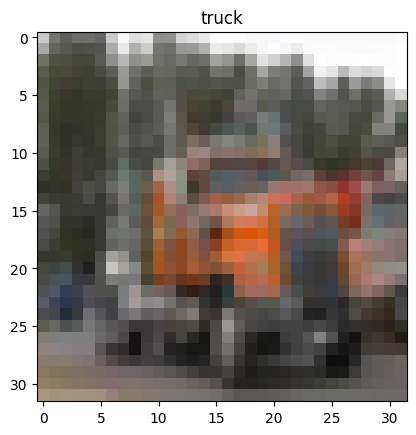

In [10]:
imshow(torchvision.utils.make_grid(tensor=[images[30]]),  label=labels[30])

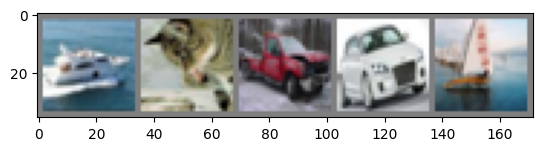

In [11]:
imshow(torchvision.utils.make_grid(images[2:7]))

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = Model().to(device)

summary(model, input_size=(3,32,32), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             216
              ReLU-2            [-1, 8, 32, 32]               0
       BatchNorm2d-3            [-1, 8, 32, 32]              16
            Conv2d-4           [-1, 16, 32, 32]           1,152
              ReLU-5           [-1, 16, 32, 32]               0
       BatchNorm2d-6           [-1, 16, 32, 32]              32
            Conv2d-7            [-1, 8, 32, 32]             128
              ReLU-8            [-1, 8, 32, 32]               0
         MaxPool2d-9            [-1, 8, 16, 16]               0
           Conv2d-10            [-1, 8, 16, 16]             576
             ReLU-11            [-1, 8, 16, 16]               0
      BatchNorm2d-12            [-1, 8, 16, 16]              16
           Conv2d-13           [-1, 16, 16, 16]           1,152
             ReLU-14           [-1, 16,

In [13]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

epoch_train_loss = []
epoch_train_acc = []
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)

        # Calculate loss
        loss = F.nll_loss(y_pred, target)
        train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)
    epoch_train_loss.append(sum(train_losses[-train_loader.batch_size:])/(train_loader.batch_size))
    epoch_train_acc.append(train_acc[-1])

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [14]:
model =  Model().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)

EPOCH: 1


Loss=1.1541768312454224 Batch_id=1562 Accuracy=42.91: 100%|██████████| 1563/1563 [00:10<00:00, 143.94it/s]



Test set: Average loss: 1.4463, Accuracy: 4841/10000 (48.41%)

EPOCH: 2


Loss=1.373030185699463 Batch_id=1562 Accuracy=53.96: 100%|██████████| 1563/1563 [00:10<00:00, 143.90it/s] 



Test set: Average loss: 1.1562, Accuracy: 5837/10000 (58.37%)

EPOCH: 3


Loss=1.5053720474243164 Batch_id=1562 Accuracy=58.94: 100%|██████████| 1563/1563 [00:10<00:00, 145.46it/s]



Test set: Average loss: 1.1464, Accuracy: 5779/10000 (57.79%)

EPOCH: 4


Loss=0.9290053248405457 Batch_id=1562 Accuracy=61.81: 100%|██████████| 1563/1563 [00:11<00:00, 132.73it/s]



Test set: Average loss: 1.0295, Accuracy: 6332/10000 (63.32%)

EPOCH: 5


Loss=0.5920490622520447 Batch_id=1562 Accuracy=64.06: 100%|██████████| 1563/1563 [00:10<00:00, 142.26it/s] 



Test set: Average loss: 0.9764, Accuracy: 6505/10000 (65.05%)

EPOCH: 6


Loss=0.8751775026321411 Batch_id=1562 Accuracy=65.50: 100%|██████████| 1563/1563 [00:10<00:00, 142.57it/s]



Test set: Average loss: 0.9737, Accuracy: 6536/10000 (65.36%)

EPOCH: 7


Loss=1.1016545295715332 Batch_id=1562 Accuracy=66.97: 100%|██████████| 1563/1563 [00:10<00:00, 142.29it/s] 



Test set: Average loss: 0.9634, Accuracy: 6612/10000 (66.12%)

EPOCH: 8


Loss=1.3447948694229126 Batch_id=1562 Accuracy=67.86: 100%|██████████| 1563/1563 [00:11<00:00, 141.78it/s] 



Test set: Average loss: 0.9433, Accuracy: 6688/10000 (66.88%)

EPOCH: 9


Loss=1.3222885131835938 Batch_id=1562 Accuracy=68.62: 100%|██████████| 1563/1563 [00:11<00:00, 132.21it/s] 



Test set: Average loss: 0.9274, Accuracy: 6796/10000 (67.96%)

EPOCH: 10


Loss=1.138019323348999 Batch_id=1562 Accuracy=69.41: 100%|██████████| 1563/1563 [00:10<00:00, 143.32it/s]  



Test set: Average loss: 0.8743, Accuracy: 6954/10000 (69.54%)

EPOCH: 11


Loss=1.4839098453521729 Batch_id=1562 Accuracy=70.08: 100%|██████████| 1563/1563 [00:11<00:00, 141.45it/s] 



Test set: Average loss: 0.9644, Accuracy: 6585/10000 (65.85%)

EPOCH: 12


Loss=0.9138537645339966 Batch_id=1562 Accuracy=70.71: 100%|██████████| 1563/1563 [00:10<00:00, 143.03it/s] 



Test set: Average loss: 0.8573, Accuracy: 7021/10000 (70.21%)

EPOCH: 13


Loss=0.6120163202285767 Batch_id=1562 Accuracy=71.14: 100%|██████████| 1563/1563 [00:10<00:00, 142.30it/s] 



Test set: Average loss: 0.8547, Accuracy: 7052/10000 (70.52%)

EPOCH: 14


Loss=0.8341264724731445 Batch_id=1562 Accuracy=71.83: 100%|██████████| 1563/1563 [00:11<00:00, 134.42it/s] 



Test set: Average loss: 0.8650, Accuracy: 6979/10000 (69.79%)

EPOCH: 15


Loss=1.0751128196716309 Batch_id=1562 Accuracy=72.00: 100%|██████████| 1563/1563 [00:10<00:00, 142.21it/s] 



Test set: Average loss: 0.8304, Accuracy: 7143/10000 (71.43%)

EPOCH: 16


Loss=0.7970969080924988 Batch_id=1562 Accuracy=72.50: 100%|██████████| 1563/1563 [00:10<00:00, 142.53it/s] 



Test set: Average loss: 0.8237, Accuracy: 7198/10000 (71.98%)

EPOCH: 17


Loss=0.7432201504707336 Batch_id=1562 Accuracy=72.67: 100%|██████████| 1563/1563 [00:10<00:00, 143.66it/s] 



Test set: Average loss: 0.8178, Accuracy: 7137/10000 (71.37%)

EPOCH: 18


Loss=0.8721840381622314 Batch_id=1562 Accuracy=72.79: 100%|██████████| 1563/1563 [00:10<00:00, 142.88it/s] 



Test set: Average loss: 0.8302, Accuracy: 7108/10000 (71.08%)

EPOCH: 19


Loss=0.4672156572341919 Batch_id=1562 Accuracy=73.11: 100%|██████████| 1563/1563 [00:10<00:00, 143.88it/s] 



Test set: Average loss: 0.8112, Accuracy: 7202/10000 (72.02%)

EPOCH: 20


Loss=0.7425115704536438 Batch_id=1562 Accuracy=73.27: 100%|██████████| 1563/1563 [00:11<00:00, 136.74it/s] 



Test set: Average loss: 0.8110, Accuracy: 7210/10000 (72.10%)

